# Cold atom workflow demonstration

In cold atoms, we do not necessarily work with qubits. As an example, we implemented here the operation on a single qudit as it is implemented in Heidelberg University. In this notebook we present the communication with our API. The communication with the backend happens through the four url

1. '.../shots/get_config/' 
2. '.../shots/post_job/'
3. '.../shots/get_job_status/'
4. '.../shots/get_job_result/'

# get config

Getting the description of the simulator/backend as a json file

* user login  at '.../get_config'
* json file with simulator/backend description 

In [1]:
import requests
import json
from pprint import pprint

This imports the `credentials.py` file you received from us.

In [2]:
#from heroku_credentials import username, password
from credentials import username, password

In [3]:
#url_prefix="http://qsimsim.synqs.org/shots/" # the cloud back-end
url_prefix = 'http://localhost:8000/shots/' # the back-end for local testing

In [4]:
url= url_prefix + "get_config/"
print(url)

r = requests.get(url,params={'username': username,'password':password})

pprint(r.text)

http://localhost:8000/shots/get_config/
('{"backend_name": "synqs_single_qudit_simulator", "cold_atom_type": "spin", '
 '"backend_version": "0.0.2", "n_qubits": 1, "atomic_species": ["na"], '
 '"basis_gates": ["rLx", "rLz", "rLz2"], "gates": [{"name": "rLz", '
 '"parameters": ["delta"], "qasm_def": "gate rLz(delta) {}", "coupling_map": '
 '[[0], [1], [2], [3], [4]], "description": "Evolution under the Z gate"}, '
 '{"name": "rLz2", "parameters": ["chi"], "qasm_def": "gate rLz2(chi) {}", '
 '"coupling_map": [[0], [1], [2], [3], [4]], "description": "Evolution under '
 'Lz2"}, {"name": "rLx", "parameters": ["omega"], "qasm_def": "gate rx(omega) '
 '{}", "coupling_map": [[0], [1], [2], [3], [4]], "description": "Evolution '
 'under Lx"}], "supported_instructions": ["rLx", "rLz", "rLz2", "measure", '
 '"barrier", "load"], "local": false, "simulator": true, "conditional": false, '
 '"open_pulse": false, "memory": true, "max_shots": 1000, "coupling_map": '
 '[[]], "max_experiments": 15, "des

# The single qudit backend

The single qudit Hilbert space is $|l, m\rangle$ with $l = 2$ and $m = -2, -1, 0, 1, ,2$ being an eigenstate of the total angular momentum
operator and the z-component

\begin{align}
    L^2 |l,m\rangle &= l (l+1) |l,m \rangle \notag  \\
    L_z |l, m\rangle &= m |l, m\rangle \notag
\end{align}

The Hamiltonian which controls the qudit is 

\begin{align}
    H = \chi L_z^2 + \Delta L_z + \Omega L_x
\end{align}
where the coupling constants $\chi$, $\Delta$ and $\Omega$ can be switched on and off individually.

We us the above Hamiltonian to generate the following three gates

* Rotation around the z-axis 
    \begin{align}
        rLz = \exp\{  i (\Delta t) L_z \} 
    \end{align}
* Rotation around the x-axis 
    \begin{align}
        rLx = \exp\{ i (\Omega t) L_x \} 
    \end{align} 
* Squeezing operation 
    \begin{align}
        rLz2 = \exp\{ i (\chi  t) L^2_z \} 
    \end{align}

## x rotation

This rotates the qudit around the x axis to put it into a superposition of z states. We start with a $\pi$ rotation i.e
    \begin{align}
        rLx = \exp\{ i \pi L_x \} 
    \end{align} 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
job_payload = {
    'experiment_0': {
    'instructions': [
        ('rLx', [0], [np.pi]),
        ('measure', [0], []),
        ],
        'num_wires': 1,
        'shots': 4,
        'seed': 12345
    },
}

Send the job to the server

In [7]:
url= url_prefix + "post_job/" 

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 56, "status": "INITIALIZING", "detail": "Got your json."}


Test for completion

In [8]:
status_payload = {'job_id': job_id}

url= url_prefix + "get_job_status/" 

status_response = requests.get(url, params={'json':json.dumps(status_payload),'username': username,'password':password})

print(status_response.text)

{"job_id": 56, "status": "DONE", "detail": "Got your json.; Passed json sanity check; Compilation done. Shots sent to solver"}


Obtaining results

In [9]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result/" 

result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})

print(result_response.text)

{"backend_name": "synqs_single_qudit_simulator", "backend_version": "0.0.2", "job_id": 56, "qobj_id": null, "success": true, "status": "finished", "header": {}, "results": [{"header": {"name": "SingleQudit", "extra metadata": "None"}, "shots": 4, "success": true, "data": {"memory": ["1", "1", "1", "1"]}}]}


the result of the calculation is then

In [10]:
res_dict = json.loads(result_response.text)
measurements = res_dict["results"][0]['data']['memory']
print(measurements)

['1', '1', '1', '1']


# Barrier gate

In [11]:
job_payload = {
    'experiment_0': {
    'instructions': [
        ('rLx', [0], [np.pi]),
        ('barrier', [], []),
        ('measure', [0], []),
        ],
        'num_wires': 1,
        'shots': 4
    },
}

Send the job to the server

In [12]:
url= url_prefix + "post_job/" 

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 57, "status": "INITIALIZING", "detail": "Got your json."}


Test for completion

In [13]:
status_payload = {'job_id': job_id}

url= url_prefix + "get_job_status/" 

status_response = requests.get(url, params={'json':json.dumps(status_payload),'username': username,'password':password})

print(status_response.text)

{"job_id": 57, "status": "DONE", "detail": "Got your json.; Passed json sanity check; Compilation done. Shots sent to solver"}


Obtaining results

In [14]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result/" 

result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})

print(result_response.text)

{"backend_name": "synqs_single_qudit_simulator", "backend_version": "0.0.2", "job_id": 57, "qobj_id": null, "success": true, "status": "finished", "header": {}, "results": [{"header": {"name": "SingleQudit", "extra metadata": "None"}, "shots": 4, "success": true, "data": {"memory": ["1", "1", "1", "1"]}}]}


the result of the calculation is then

In [15]:
res_dict = json.loads(result_response.text)
measurements = res_dict["results"][0]['data']['memory']
print(measurements)

['1', '1', '1', '1']


## Rabi oscillation

The following section creates a Rabi-oscillation

Create several jobs determined by the phase  

In [16]:
n_phases = 11 # number of phases we would like to investigate
phases = np.linspace(0,2*np.pi,n_phases) #array of phases
job_payload = {}

for ii in range(n_phases):
    exp_str = 'experiment_' + str(ii)
    dummy_exp = {
        'instructions': [
            ('rLx', [0], [phases[ii]]),
            ('measure', [0], []),
            ],
            'num_wires': 1,
            'shots': 4
    }
    job_payload[exp_str] = dummy_exp
pprint(job_payload)

{'experiment_0': {'instructions': [('rLx', [0], [0.0]), ('measure', [0], [])],
                  'num_wires': 1,
                  'shots': 4},
 'experiment_1': {'instructions': [('rLx', [0], [0.6283185307179586]),
                                   ('measure', [0], [])],
                  'num_wires': 1,
                  'shots': 4},
 'experiment_10': {'instructions': [('rLx', [0], [6.283185307179586]),
                                    ('measure', [0], [])],
                   'num_wires': 1,
                   'shots': 4},
 'experiment_2': {'instructions': [('rLx', [0], [1.2566370614359172]),
                                   ('measure', [0], [])],
                  'num_wires': 1,
                  'shots': 4},
 'experiment_3': {'instructions': [('rLx', [0], [1.8849555921538759]),
                                   ('measure', [0], [])],
                  'num_wires': 1,
                  'shots': 4},
 'experiment_4': {'instructions': [('rLx', [0], [2.5132741228718345]),
      

Send the job to the server via request.post(...)

In [17]:
url= url_prefix + "post_job/"

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 58, "status": "INITIALIZING", "detail": "Got your json."}


Test if the job is completed

In [18]:
status_payload = {'job_id': job_id}

url= url_prefix + "get_job_status/"
status_response = requests.get(url, params={'json':json.dumps(status_payload),'username': username,'password':password})

print(status_response.text)

{"job_id": 58, "status": "DONE", "detail": "Got your json.; Passed json sanity check; Compilation done. Shots sent to solver"}


and obtain the results via requests.get(...)

In [19]:
result_payload = {'job_id': job_id}

url= url_prefix + "get_job_result/"
result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})
results_dict = json.loads(result_response.text)
pprint(results_dict)

{'backend_name': 'synqs_single_qudit_simulator',
 'backend_version': '0.0.2',
 'header': {},
 'job_id': 58,
 'qobj_id': None,
 'results': [{'data': {'memory': ['0', '0', '0', '0']},
              'header': {'extra metadata': 'None', 'name': 'SingleQudit'},
              'shots': 4,
              'success': True},
             {'data': {'memory': ['0', '0', '0', '0']},
              'header': {'extra metadata': 'None', 'name': 'SingleQudit'},
              'shots': 4,
              'success': True},
             {'data': {'memory': ['1', '1', '1', '1']},
              'header': {'extra metadata': 'None', 'name': 'SingleQudit'},
              'shots': 4,
              'success': True},
             {'data': {'memory': ['1', '1', '1', '0']},
              'header': {'extra metadata': 'None', 'name': 'SingleQudit'},
              'shots': 4,
              'success': True},
             {'data': {'memory': ['1', '1', '1', '1']},
              'header': {'extra metadata': 'None', 'name': 'Si

The result of the calculation

In [20]:
measurements = []
for res in results_dict["results"]:
    shots = np.array(res['data']['memory'])
    shots = [shot.split(' ') for shot in shots]
    #print(shots.shape)
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el][0]
    measurements.append(shots)
    
measurements = np.array(measurements)

Text(0.5, 0, '$\\phi_z$')

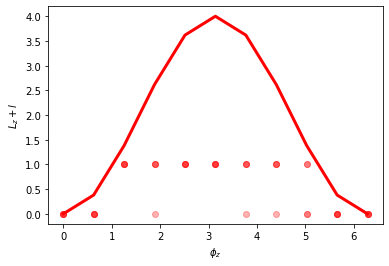

In [21]:
f, ax = plt.subplots()
ax.plot(phases, measurements, 'ro', alpha = 0.3)
ax.plot(phases, 2*(1-np.cos(phases)), 'r-', lw = 3)
ax.set_ylabel(r'$L_z + l$')
ax.set_xlabel(r'$\phi_z$')

## Ramsey cycle

The gate sequence for the Ramsey cycle is $e^{i (\pi/2) L_x} e^{i \varphi L_z} e^{i (\pi/2) L_x}$

In [22]:
n_phases = 11 # number of phases we would like to investigate
phases = np.linspace(0,2*np.pi,n_phases)
job_payload = {}

for ii in range(n_phases):
    exp_str = 'experiment_' + str(ii)
    dummy_exp = {
        'instructions': [
            ('rLx', [0], [np.pi/2]),
            ('rLz', [0], [phases[ii]]),
            ('rLx', [0], [np.pi/2]),
            ('measure', [0], []),
            ],
            'num_wires': 1,
            'shots': 5
    }
    job_payload[exp_str] = dummy_exp
print(job_payload)

{'experiment_0': {'instructions': [('rLx', [0], [1.5707963267948966]), ('rLz', [0], [0.0]), ('rLx', [0], [1.5707963267948966]), ('measure', [0], [])], 'num_wires': 1, 'shots': 5}, 'experiment_1': {'instructions': [('rLx', [0], [1.5707963267948966]), ('rLz', [0], [0.6283185307179586]), ('rLx', [0], [1.5707963267948966]), ('measure', [0], [])], 'num_wires': 1, 'shots': 5}, 'experiment_2': {'instructions': [('rLx', [0], [1.5707963267948966]), ('rLz', [0], [1.2566370614359172]), ('rLx', [0], [1.5707963267948966]), ('measure', [0], [])], 'num_wires': 1, 'shots': 5}, 'experiment_3': {'instructions': [('rLx', [0], [1.5707963267948966]), ('rLz', [0], [1.8849555921538759]), ('rLx', [0], [1.5707963267948966]), ('measure', [0], [])], 'num_wires': 1, 'shots': 5}, 'experiment_4': {'instructions': [('rLx', [0], [1.5707963267948966]), ('rLz', [0], [2.5132741228718345]), ('rLx', [0], [1.5707963267948966]), ('measure', [0], [])], 'num_wires': 1, 'shots': 5}, 'experiment_5': {'instructions': [('rLx', [0

we first send the job to the server

In [23]:
url= url_prefix + "post_job/"

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 59, "status": "INITIALIZING", "detail": "Got your json."}


Test for completion.

In [24]:
status_payload = {'job_id': job_id}
url= url_prefix + "get_job_status/"

status_response = requests.get(url, params={'json':json.dumps(status_payload),'username': username,'password':password})

print(status_response.text)

{"job_id": 59, "status": "DONE", "detail": "Got your json.; Passed json sanity check; Compilation done. Shots sent to solver"}


Obtaining results

In [25]:
result_payload = {'job_id': job_id}

url= url_prefix + "get_job_result/"
result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})
results_dict = json.loads(result_response.text)
print(result_response.text)

{"backend_name": "synqs_single_qudit_simulator", "backend_version": "0.0.2", "job_id": 59, "qobj_id": null, "success": true, "status": "finished", "header": {}, "results": [{"header": {"name": "SingleQudit", "extra metadata": "None"}, "shots": 5, "success": true, "data": {"memory": ["1", "1", "1", "1", "1"]}}, {"header": {"name": "SingleQudit", "extra metadata": "None"}, "shots": 5, "success": true, "data": {"memory": ["1", "1", "1", "1", "1"]}}, {"header": {"name": "SingleQudit", "extra metadata": "None"}, "shots": 5, "success": true, "data": {"memory": ["1", "0", "0", "1", "1"]}}, {"header": {"name": "SingleQudit", "extra metadata": "None"}, "shots": 5, "success": true, "data": {"memory": ["0", "1", "0", "1", "0"]}}, {"header": {"name": "SingleQudit", "extra metadata": "None"}, "shots": 5, "success": true, "data": {"memory": ["0", "0", "0", "0", "0"]}}, {"header": {"name": "SingleQudit", "extra metadata": "None"}, "shots": 5, "success": true, "data": {"memory": ["0", "0", "0", "0", "

The result of the Ramsey cycle is

In [26]:
measurements = []
for res in results_dict["results"]:
    shots = np.array(res['data']['memory'])
    shots = [shot.split(' ') for shot in shots]
    #print(shots.shape)
    for ii, el in enumerate(shots):
        shots[ii] = [int(meas) for meas in el][0]
    measurements.append(shots)
    
measurements = np.array(measurements)

Text(0.5, 0, '$\\phi_z$')

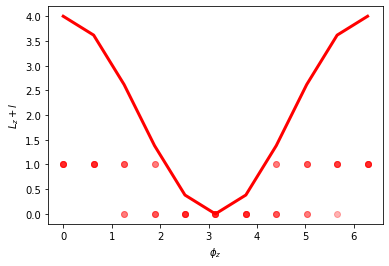

In [27]:
f, ax = plt.subplots()
ax.plot(phases, measurements, 'ro', alpha = 0.3)
ax.plot(phases, 2*(1+np.cos(phases)), 'r-', lw = 3)
ax.set_ylabel(r'$L_z + l$')
ax.set_xlabel(r'$\phi_z$')

# Load gate

we need to make it possible to change the length of the spin. So we will introduce the load gate. The second parameter describes the number of atoms loaded onto the wire.

In [28]:
job_payload = {
    'experiment_0': {
    'instructions': [
        ('load', [0], [50]),
        ('rLx', [0], [np.pi]),
        ('measure', [0], []),
        ],
        'num_wires': 1,
        'shots': 4
    },
}

In [29]:
url= url_prefix + "post_job/" 

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 60, "status": "INITIALIZING", "detail": "Got your json."}


In [30]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result/" 

result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})

print(result_response.text)

{"backend_name": "synqs_single_qudit_simulator", "backend_version": "0.0.2", "job_id": 60, "qobj_id": null, "success": true, "status": "finished", "header": {}, "results": [{"header": {"name": "SingleQudit", "extra metadata": "None"}, "shots": 4, "success": true, "data": {"memory": ["50", "50", "50", "50"]}}]}


# Test the seed

In [40]:
job_payload = {
            'experiment_0': {
                'instructions': [
                    ('load', [0], [50]),
                    ('rLx', [0], [np.pi/2]),
                    ('measure', [0], []),
                ],
                'num_wires': 1,
                'shots': 3,
                'seed': 12345
            },
            'experiment_1': {
                'instructions': [
                    ('load', [0], [50]),
                    ('rLx', [0], [np.pi/2]),
                    ('measure', [0], []),
                ],
                'num_wires': 1,
                'shots': 3,
                'seed': 12345
            },
        }

In [41]:
url= url_prefix + "post_job/" 

job_response = requests.post(url, data={'json':json.dumps(job_payload),'username': username,'password':password})
job_id = (job_response.json())['job_id']
print(job_response.text)

{"job_id": 64, "status": "INITIALIZING", "detail": "Got your json."}


In [43]:
result_payload = {'job_id': job_id}
url= url_prefix + "get_job_result/" 

result_response = requests.get(url, params={'json':json.dumps(result_payload),'username': username,'password':password})
results_dict = json.loads(result_response.text)
pprint(results_dict)

{'backend_name': 'synqs_single_qudit_simulator',
 'backend_version': '0.0.2',
 'header': {},
 'job_id': 64,
 'qobj_id': None,
 'results': [{'data': {'memory': ['30', '23', '22']},
              'header': {'extra metadata': 'None', 'name': 'SingleQudit'},
              'shots': 3,
              'success': True},
             {'data': {'memory': ['30', '23', '22']},
              'header': {'extra metadata': 'None', 'name': 'SingleQudit'},
              'shots': 3,
              'success': True}],
 'status': 'finished',
 'success': True}
